In [104]:
import utilities as utils
import configs_py3 as configs
import pandas as pd
import importlib

import string

In [105]:
importlib.reload(configs)
importlib.reload(utils)

/n/fs/nlp-runzhey/miniconda3/envs/iw_vqa/lib/python3.7/site-packages/transformers/models/yolos/feature_extraction_yolos.py:31: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  FutureWarning,
/n/fs/nlp-runzhey/miniconda3/envs/iw_vqa/lib/python3.7/site-packages/transformers/models/yolos/image_processing_yolos.py:707: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  FutureWarning,


KeyboardInterrupt: 

In [ ]:
val_df = utils.load_dataset("val")

In [ ]:
image_caption = []
for image_id in val_df["image_id"]:
    image_file_path = f"{configs.ROOT}/VQA/Images/mscoco/val2014/COCO_val2014_{image_id:012d}.jpg"
    
    image_caption.append(utils.get_image_caption(image_file_path))
    
val_df["image_caption"] = image_caption

In [ ]:
val_df = utils.get_preds(val_df)

In [ ]:
val_df.to_csv(f"{configs.ROOT}/output/{configs.today}-val_df-image-captioning.csv", index=False)

In [ ]:
yesterday = "2023-03-27"
val_df = pd.read_csv(f"{configs.ROOT}/output/{yesterday}-val_df-image-captioning.csv")

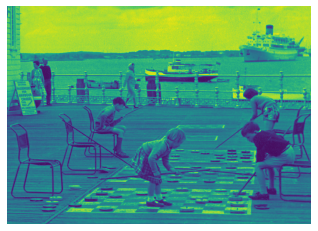

Unsupported number of image dimensions: 2 ==> Skipping this image


In [ ]:
val_df = utils.get_preds(val_df) 

In [ ]:
val_df.to_csv(f"{configs.ROOT}/output/{configs.today}-val_df-image-captioning.csv", index=False)

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [106]:
def is_question_related_to_image_caption(question, image_caption):
    max_similarity_score = 0
    is_similar_final = False
    most_similar_words = (None, None)
    image_caption = remove_punctuation(image_caption)
    question = remove_punctuation(question)
    
    image_caption_nouns = utils.get_nouns(image_caption)
    question_nouns = utils.get_nouns(question)
    
    if len(question_nouns) == 0 or len(image_caption_nouns) == 0:
        
        return True, most_similar_words, max_similarity_score
    
    for word1 in image_caption_nouns:
        for word2 in question_nouns:
            
            is_similar_bool, similarity_score = utils.is_similar(word1, word2)
            
            max_similarity_score = max(max_similarity_score, similarity_score)
            
            is_similar_final = is_similar_final or is_similar_bool
            
            if max_similarity_score == similarity_score:
                most_similar_words = (word1, word2)
            
    if is_similar_final:
        
        return True, most_similar_words, max_similarity_score
    
    return False, most_similar_words, max_similarity_score

In [115]:
modified_output = []
is_related_arr = []
similarity_arr = []
for index, row in val_df.iterrows():
    caption = row["image_caption"]
    original_model_output = row["original_model_outputs"]
    
    if index < len(val_df) // 2:
        question = row.original_question
    else:
        question = row.random_question
        
    is_related_out, most_similar_words_out, similarity_score_out = is_question_related_to_image_caption(original_model_output, caption) 
    is_related_q, most_similar_words_q, similarity_score_q = is_question_related_to_image_caption(question, caption)
    similarity_arr.append((similarity_score_out, similarity_score_q))
    is_related = is_related_out or is_related_q
    is_related_arr.append(is_related)
    modified_output.append(original_model_output if is_related else "ABSTAIN")
    # if index < len(val_df) // 2 and is_related==False:
    #     print(is_question_related_to_image_caption(original_model_output, caption), is_question_related_to_image_caption(question, caption))
    #     print(index, is_related, most_similar_words_out + most_similar_words_q, (similarity_score_out, similarity_score_q), question, original_model_output, caption)
    # elif index >= len(val_df) // 2 and is_related==True:
    #     print(index, is_related, most_similar_words_out + most_similar_words_q, (similarity_score_out, similarity_score_q), question, original_model_output, caption)

# val_df["modified_model_outputs"] = modified_output

In [117]:
val_df["modified_out"] = modified_output
val_df["similarity_caption"] = similarity_arr
val_df.modified_out[:len(val_df) // 2].value_counts(), val_df.modified_out[len(val_df) // 2:].value_counts()

(ABSTAIN     34
 white       19
 red         15
 blue        13
 yellow      11
             ..
 brick        1
 fries        1
 mario        1
 students     1
 main         1
 Name: modified_out, Length: 269, dtype: int64,
 ABSTAIN       60
 nothing       45
 white         31
 black         24
 blue          12
               ..
 eating         1
 skateboard     1
 donut          1
 baseball       1
 no train       1
 Name: modified_out, Length: 208, dtype: int64)

In [134]:
sims_cap = [val_df.similarity_caption[i][0] for i in range(len(val_df))]
sims_q = [val_df.similarity_caption[i][1] for i in range(len(val_df))]
import numpy as np
np.mean(sims_q[:len(val_df) // 2]), np.mean(sims_q[len(val_df) // 2:]), np.mean(sims_cap[:len(val_df) // 2]), np.mean(sims_cap[len(val_df) // 2:])


(0.5040141996891997,
 0.2580080752580753,
 0.2957245901157666,
 0.23605563603063603)

In [114]:
val_df.to_csv(f"{configs.ROOT}/output/{configs.today}-val_df-image-captioning.csv", index=False)

In [ ]:
question = "a quick brown fox jumps over the lazy dog"
utils.get_nouns(question)

['quick', 'brown', 'fox', 'over', 'dog']